In [1]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import numpy as np

# CEO-Request Challenge

## 1. Summary of Problem Statement

❓ **How could Olist improve its profit** ❓

### P&L Rules

#### Revenues  
**Sales fees:** Olist takes a **10% cut** on the product price (excl. freight) of each order delivered  
**Subscription fees:** Olist charges **80 BRL by month** per seller

#### Costs
**Reputation costs** *estimated* per order with bad reviews (<= 3 stars)  

💡 In the long term, bad customer experience has business implications: low repeat rate, immediate customer support cost, refunds or unfavorable word of mouth communication. We will assume that we have an estimate measure of the monetary cost for each bad review:
```python
# review_score: cost(BRL)
{'1 star': 100
'2 stars': 50
'3 stars': 40
'4 stars': 0
'5 stars': 0}
```

**IT costs:** Olist's **total cumulated IT Costs** scale with the square root of the total number of sellers that has ever join the platform, as well as the square root of the total cumulated number of products that was ever sold.  

$IT\_costs = \alpha * \sqrt{n\_sellers} + \beta * \sqrt{n\_products}$  
Olist's data team gave us the following values for these scaling parameters:
- $\alpha = 3157.27$
- $\beta = 978.23$

💡 Both number of sellers to manage and sales transaction are costly for IT systems.  
💡 Yet square roots reflect scale-effects: IT-system are often more efficient as they grow bigger.  
💡 Alpha > Beta means that "Olist has a lower IT Cost with few sellers selling a lot of products rather than the opposite  
- with **1000 sellers** and a total of **100 products** sold, the total IT cost accumulates to 109,624 BRL
- with **100 sellers** and a total of **1000 products** sold, the total IT cost accumulates to 62,507 BRL

Finally, The IT department also told you that since the birth of the marketplace, cumulated IT costs have amounted to **500,000 BRL**.

### Key Findings, so far

- `wait_time` is the most significant factor behind low review scores  
- `wait_time` is made up of seller's `delay_to_carrier` + `carrier_delivery_time`.  
- The latter being outside of Olist's direct control, improving it is not a quick-win recommendation
- On the contrary, a better selection of `sellers` can positively impact the `delay_to_carrier` and reduce the number of bad `review_scores` on Olist.
- Comments of the bad reviews showed that some were linked to the seller or to the product itself.

💡 We recommend you to start with the the guided seller analysis in part 2 below  
💪 But feel free to investigate into other hypothesis instead with part 3

## 2. Should Olist remove under-performing sellers from its marketplace? 🕵🏻
*(recommended)*

To analyze the impact of removing the worse sellers from Olist's marketplace, we will perform a **what-if analysis**

👉 **What would have happened if Olist had never accepted these sellers in the first place?**  

*(In practice, it's hard to know in advance who is a good seller, but let's start with this approach and iterate later).*

### 2.1 Data Preparation

Compute, for each `seller_id`, and cumulated since the beginning:
- the `revenues` it brings
- the `review_costs` associated with all its bad reviews
- the resulting `profits` (revenues - costs)

👉 Write down a step-by-step strategy to create the DataFrame you need


⚠️ Don't start from scratch, update your existing package 😉

Starting from the `Seller` class of your `olist` package:

Edit the `get_training_data` method so that the DataFrame it returns contains the fields:
- `revenues`: sum of subscription and sales fees revenues
- `cost_of_reviews`: sum of costs associated with bad reviews
- `profits`: `revenues` - `cost_of_reviews`

# Step 1

## Load Data

In [2]:
from olist.seller import Seller
seller=Seller(); sellers=seller.get_training_data() 

/home/joharlewagon/code/UKVeteran/04-Decision-Science/04-Logistic-Regression/data-recap_ceo_request
/home/joharlewagon/code/UKVeteran/04-Decision-Science
/home/joharlewagon/code/UKVeteran/04-Decision-Science/01-Project-Setup/data-context-and-setup/data/csv
olist_sellers_dataset.csv
olist_order_reviews_dataset.csv
olist_order_items_dataset.csv
.keep
olist_customers_dataset.csv
olist_orders_dataset.csv
olist_order_payments_dataset.csv
product_category_name_translation.csv
olist_products_dataset.csv
olist_geolocation_dataset.csv
/home/joharlewagon/code/UKVeteran/04-Decision-Science/04-Logistic-Regression/data-recap_ceo_request
/home/joharlewagon/code/UKVeteran/04-Decision-Science
/home/joharlewagon/code/UKVeteran/04-Decision-Science/01-Project-Setup/data-context-and-setup/data/csv
olist_sellers_dataset.csv
olist_order_reviews_dataset.csv
olist_order_items_dataset.csv
.keep
olist_customers_dataset.csv
olist_orders_dataset.csv
olist_order_payments_dataset.csv
product_category_name_translati

In [3]:
sellers.head(2)

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,review_score,cost_of_reviews,n_orders,quantity,quantity_per_order,sales,revenues,profits
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.0,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,0.333333,0.333333,3.00,140,3,3,1.000,218.70,341.870,201.870
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.0,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,0.050000,0.725000,4.55,240,40,41,1.025,11703.07,2290.307,2050.307


# Columns We Want

In [4]:
useful_columns = [ 'seller_id', 'date_first_sale', 'date_last_sale', 'sales' ] 
sellers_1 = sellers[useful_columns].copy()
sellers_1.head(2)

,seller_id,date_first_sale,date_last_sale,sales
0,3442f8959a84dea7ee197c632cb2df15,2017-05-05 16:25:11,2017-08-30 12:50:19,218.70
1,d1b65fc7debc3361ea86b5f14c68d2e2,2017-03-29 02:10:34,2018-06-06 20:15:21,11703.07


 # Revenues
 ## Sales fees: Olist takes a 10% cut on the product price (excl. freight) of each order delivered
## Subscription fees: Olist charges 80 BRL by month per seller

In [5]:
sellers_1['active_months'] = \
          (sellers_1['date_last_sale'] - sellers_1['date_first_sale']) / np.timedelta64(1,'M')
sellers_1['revenues'] = sellers_1['sales'].map(lambda x : .1*x) \
                       + sellers_1['active_months']*80
sellers_1.head(2)

,seller_id,date_first_sale,date_last_sale,sales,active_months,revenues
0,3442f8959a84dea7ee197c632cb2df15,2017-05-05 16:25:11,2017-08-30 12:50:19,218.70,3.839119,328.999525
1,d1b65fc7debc3361ea86b5f14c68d2e2,2017-03-29 02:10:34,2018-06-06 20:15:21,11703.07,14.283770,2313.008599


In [6]:
sellers_1['revenues2'] = sellers_1['sales']*0.1+80*sellers_1['active_months']
sellers_1.head(10)

,seller_id,date_first_sale,date_last_sale,sales,active_months,revenues,revenues2
0,3442f8959a84dea7ee197c632cb2df15,2017-05-05 16:25:11,2017-08-30 12:50:19,218.70,3.839119,328.999525,328.999525
1,d1b65fc7debc3361ea86b5f14c68d2e2,2017-03-29 02:10:34,2018-06-06 20:15:21,11703.07,14.283770,2313.008599,2313.008599
2,ce3ad9de960102d0677a81f5d0bb7b2d,2018-07-30 12:44:49,2018-07-30 12:44:49,158.00,0.000000,15.800000,15.800000
3,c0f3eea2e14555b6faeea3dd58c1b1c3,2018-08-03 00:44:08,2018-08-03 00:44:08,79.99,0.000000,7.999000,7.999000
4,51a04a8a6bdcb23deccc82b0b80742cf,2017-11-14 12:15:25,2017-11-14 12:15:25,167.99,0.000000,16.799000,16.799000
5,c240c4061717ac1806ae6ee72be3533b,2018-05-08 17:55:23,2018-05-08 17:55:23,59.90,0.000000,5.990000,5.990000
6,e49c26c3edfa46d227d5121a6b6e4d37,2017-02-04 19:31:42,2018-07-25 14:30:27,3654.25,17.603345,1773.692567,1773.692567
7,1b938a7ec6ac5061a66a3766e0e75f90,2017-09-23 17:24:32,2018-08-18 19:09:29,3987.60,10.811651,1263.692111,1263.692111
8,768a86e36ad6aae3d03ee3c6433d61df,2018-06-19 12:18:24,2018-08-24 03:15:18,587.46,2.156031,231.228483,231.228483
9,ccc4bbb5f32a6ab2b7066a4130f114e3,2017-01-07 14:00:13,2018-08-21 21:05:16,74004.62,19.426934,8954.616751,8954.616751


In [7]:
total_revenues = sellers_1['revenues'].sum()
print("Revenues of all sellers :", total_revenues)

Revenues of all sellers : 2787067.4342827117


# Total Revenue: 2_787_067 BRL

In [8]:
ssellers_1 = sellers_1.sort_values(by='revenues')
ssellers_1

,seller_id,date_first_sale,date_last_sale,sales,active_months,revenues,revenues2
2239,77128dec4bec4878c37ab7d6169d6f26,2017-03-15 20:14:39,2017-03-15 20:14:39,6.50,0.000000,0.650000,0.650000
2014,1fa2d3def6adfa70e58c276bb64fe5bb,2018-08-24 13:24:27,2018-08-24 13:24:27,6.90,0.000000,0.690000,0.690000
2312,702835e4b785b67a084280efca355756,2017-02-14 03:42:56,2017-02-14 03:42:56,7.60,0.000000,0.760000,0.760000
2322,ad14615bdd492b01b0d97922e87cb87f,2017-02-10 17:50:14,2017-02-10 17:50:14,8.25,0.000000,0.825000,0.825000
1408,4965a7002cca77301c82d3f91b82e1a9,2018-04-24 18:49:47,2018-04-24 18:49:47,8.49,0.000000,0.849000,0.849000
...,...,...,...,...,...,...,...
1132,7c67e1448b00f6e969d365cea6b010ab,2017-01-26 22:55:10,2018-08-08 03:10:34,187923.89,18.338852,20259.497200,20259.497200
534,fa1c13f2614d7b5c4749cbc52fecda94,2017-01-07 20:55:10,2018-08-29 10:04:16,194042.03,19.665225,20977.420976,20977.420976
2358,4a3ca9315b744ce9f8e9374361493884,2017-01-08 09:45:12,2018-08-27 11:04:18,200472.92,19.583316,21613.957252,21613.957252
868,53243585a1d6dc2643021fd1853d8905,2017-08-28 18:44:58,2018-08-21 16:35:26,222776.05,11.759093,23218.332447,23218.332447


## Tried Plotting but did not work due to indexing. Need to reset.

Text(0, 0.5, 'revenues')

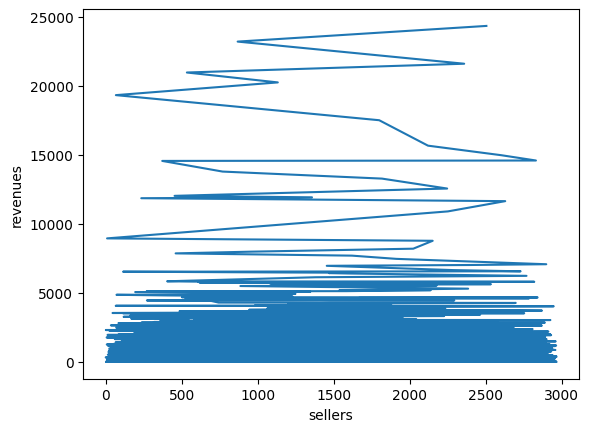

In [9]:
sorted_sellers_1 = sellers_1.sort_values(by='revenues')

sorted_sellers_1.revenues.plot()
plt.xlabel('sellers'); plt.ylabel('revenues')

## Index Reset. A much better plot.

Text(0, 0.5, 'revenues')

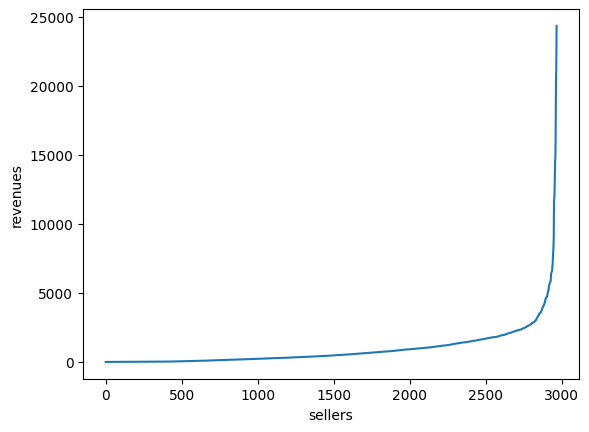

In [10]:
sorted_sellers_1 = sellers_1.sort_values(by='revenues').reset_index()

sorted_sellers_1.revenues.plot()
plt.xlabel('sellers'); plt.ylabel('revenues')

In [11]:
round( sellers_1[['seller_id', 'revenues']] , 2) \
                        .sort_values(by = 'revenues') \
                        .head(10)  

,seller_id,revenues
2239,77128dec4bec4878c37ab7d6169d6f26,0.65
2014,1fa2d3def6adfa70e58c276bb64fe5bb,0.69
2312,702835e4b785b67a084280efca355756,0.76
2322,ad14615bdd492b01b0d97922e87cb87f,0.82
1408,4965a7002cca77301c82d3f91b82e1a9,0.85
2492,0f94588695d71662beec8d883ffacf09,0.90
2896,c18309219e789960add0b2255ca4b091,0.99
2953,95cca791657aabeff15a07eb152d7841,1.00
1824,344223b2a90784f64136a8a5da012e7f,1.09
2079,3ac588cd562971392504a9e17130c40b,1.19


In [12]:
round( sellers_1[['seller_id', 'revenues']] , 2 ) \
                        .sort_values(by = 'revenues') \
                        .tail(3) 

,seller_id,revenues
2358,4a3ca9315b744ce9f8e9374361493884,21613.96
868,53243585a1d6dc2643021fd1853d8905,23218.33
2504,4869f7a5dfa277a7dca6462dcf3b52b2,24354.20


# Cumulative sum of revenues

## Using Pandas

Text(0, 0.5, 'Cumulative sum of revenues')

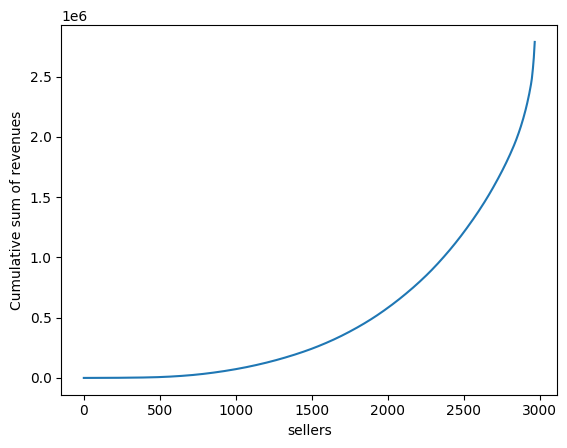

In [13]:
sorted_sellers_1.revenues.cumsum().plot();
plt.xlabel('sellers'); plt.ylabel('Cumulative sum of revenues')

## Using NumPy

Text(0, 0.5, 'Cumulative sum of revenues')

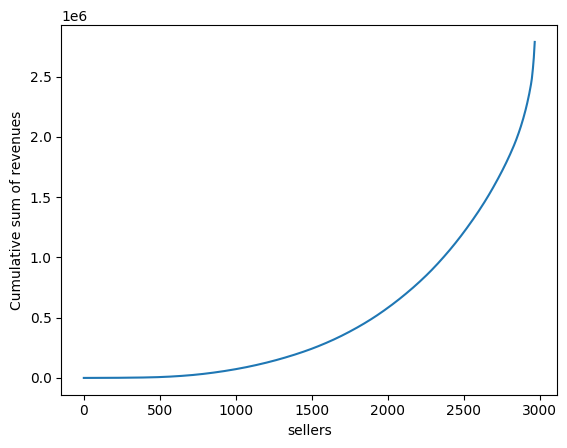

In [14]:
np.cumsum(sorted_sellers_1.revenues).plot();
plt.xlabel('sellers'); plt.ylabel('Cumulative sum of revenues')

# Step 2

## Total costs - Bad Reviews

In [15]:
from olist.order import Order
order=Order()
orders=order.get_training_data()

/home/joharlewagon/code/UKVeteran/04-Decision-Science/04-Logistic-Regression/data-recap_ceo_request
/home/joharlewagon/code/UKVeteran/04-Decision-Science
/home/joharlewagon/code/UKVeteran/04-Decision-Science/01-Project-Setup/data-context-and-setup/data/csv
olist_sellers_dataset.csv
olist_order_reviews_dataset.csv
olist_order_items_dataset.csv
.keep
olist_customers_dataset.csv
olist_orders_dataset.csv
olist_order_payments_dataset.csv
product_category_name_translation.csv
olist_products_dataset.csv
olist_geolocation_dataset.csv


In [16]:
useful_columns = ['order_id', 'review_score']
orders_1 = orders[useful_columns].copy()
orders_1.shape

(96353, 2)

In [17]:
from olist.data import Olist
olist=Olist()
matching_table = olist.get_matching_table() 
matching_table.shape

/home/joharlewagon/code/UKVeteran/04-Decision-Science/04-Logistic-Regression/data-recap_ceo_request
/home/joharlewagon/code/UKVeteran/04-Decision-Science
/home/joharlewagon/code/UKVeteran/04-Decision-Science/01-Project-Setup/data-context-and-setup/data/csv
olist_sellers_dataset.csv
olist_order_reviews_dataset.csv
olist_order_items_dataset.csv
.keep
olist_customers_dataset.csv
olist_orders_dataset.csv
olist_order_payments_dataset.csv
product_category_name_translation.csv
olist_products_dataset.csv
olist_geolocation_dataset.csv


(114092, 5)

## Run Some Diagnostics as the dimensions of the resulting tables did not match

In [18]:
matching_table.head(5)

,customer_id,order_id,review_id,product_id,seller_id
0,9ef432eb6251297304e76186b10a928d,e481f51cbdc54678b7cc49136f2d6af7,a54f0611adc9ed256b57ede6b6eb5114,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9
1,b0830fb4747a6c6d20dea0b8c802d7ef,53cdb2fc8bc7dce0b6741e2150273451,8d5266042046a06655c8db133d120ba5,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962
2,41ce2a54c0b03bf3443c3d931a367089,47770eb9100c2d0c44946d9cf07ec65d,e73b67b67587f7644d5bd1a52deb1b01,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2
3,f88197465ea7920adcdbec7375364d82,949d5b44dbf5de918fe9c16f97b45f8a,359d03e676b3c069f62cadba8dd3f6e8,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106
4,8ab97904e6daea8866dbdbc4fb7aad2c,ad21c59c0840e6cb83a9ceb5573f8159,e50934924e227544ba8246aeb3770dd4,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8


In [19]:
useful_columns = ['order_id', 'review_score']
orders_1 = orders[useful_columns].copy()
orders_1.head(2)
df1=orders_1.head(20)
df1.shape

(20, 2)

## To remedy the error it is better to use the whole matching table and orders to merge on order_id

In [20]:
costs =matching_table.merge(orders , on = 'order_id')
costs.shape

(111303, 16)

## The above shape is something I am happy with

In [21]:
costs[['order_id','review_score']]

,order_id,review_score
0,e481f51cbdc54678b7cc49136f2d6af7,4
1,53cdb2fc8bc7dce0b6741e2150273451,4
2,47770eb9100c2d0c44946d9cf07ec65d,5
3,949d5b44dbf5de918fe9c16f97b45f8a,5
4,ad21c59c0840e6cb83a9ceb5573f8159,5
...,...,...
111298,63943bddc261676b46f01ca7ac2f7bd8,4
111299,83c1379a015df1e13d02aae0204711ab,5
111300,11c177c8e97725db2631073c19f07b62,2
111301,11c177c8e97725db2631073c19f07b62,2


## Need to create a dictionary

In [22]:
def review_to_price(review_score): 
    d = {1 : 100, 2 : 50, 3 : 40, 4 : 0, 5: 0}
    return d[review_score]

In [23]:
costs['costs'] = costs['review_score'].map(review_to_price)
costs_1 = costs[['seller_id', 'costs']].copy()
costs_1.shape

(111303, 2)

In [24]:
costs_2=costs_1.drop_duplicates()

In [25]:
costs_2.shape

(6651, 2)

In [26]:
print("Costs for all sellers: ", costs_1.costs.sum() , "BRL")

Costs for all sellers:  1837830 BRL


In [27]:
olist_costs = costs_1.groupby('seller_id').sum().reset_index()
olist_costs.sort_values(by = 'costs') .head(3)

,seller_id,costs
1482,7cf4ea70955b00d6b3c22542598e2715,0
2061,b2eecf5ea250510da76590ca79d60e5d,0
2062,b2f4d63c7203f539a78252565ca32257,0


In [28]:
olist_costs.sort_values(by = 'costs') .tail(3)

,seller_id,costs
358,1f50f920176fa81dab994f9023523100,37950
857,4a3ca9315b744ce9f8e9374361493884,43510
1478,7c67e1448b00f6e969d365cea6b010ab,43990


In [29]:
total_costs = olist_costs['costs'].sum()
print("The costs associated with all this : ", total_costs )

The costs associated with all this :  1837830


Text(0, 0.5, 'Costs')

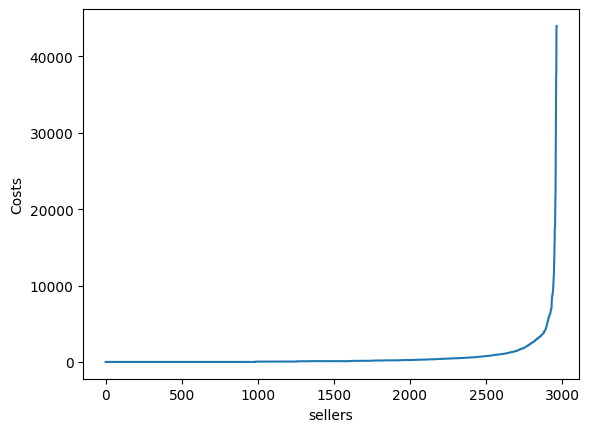

In [30]:
sorted_costs = olist_costs.sort_values(by='costs').reset_index()
sorted_costs.costs.plot();
plt.xlabel('sellers'); plt.ylabel('Costs')

Text(0, 0.5, 'Cumulative sum of Costs')

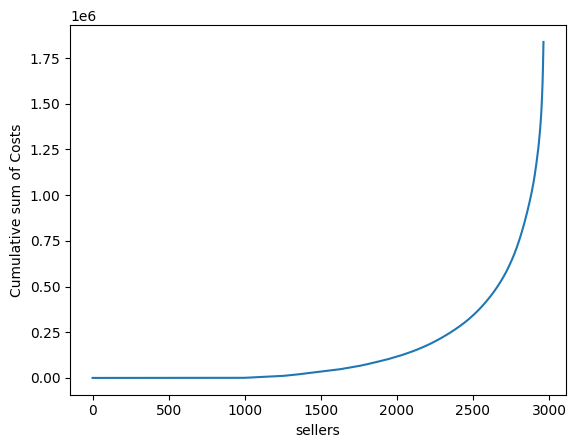

In [31]:
np.cumsum(sorted_costs.costs).plot();
plt.xlabel('sellers'); plt.ylabel('Cumulative sum of Costs')

## Plotting Revenue and Costs Together

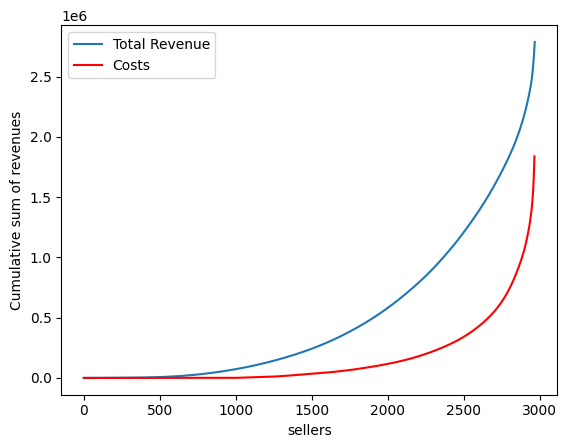

In [32]:
# Revenues
np.cumsum(sorted_sellers_1.revenues).plot( label ='Total Revenue');
plt.xlabel('sellers'); plt.ylabel('Cumulative sum of revenues')

# Costs
np.cumsum(sorted_costs.costs).plot(color = 'r', label = 'Costs');
plt.legend()

In [33]:
print( " Total Revenue : ", round(total_revenues, 2))
print( " Total Costs : ", round(total_costs, 2))

profits =  total_revenues - total_costs
print( " The total resulting profits : ", round(profits, 2))

 Total Revenue :  2787067.43
 Total Costs :  1837830
 The total resulting profits :  949237.43


## Resulting Final Profits Excl. IT Costs

In [34]:
IT_costs = 500_000
print("The final resulting profits : ",  round(profits - IT_costs, 2))

The final resulting profits :  449237.43


### 2.2 What-if Analysis

👉 Time to perform the actual analysis, here are our steps:  

1️⃣ Create a method that will help us update the IT Costs after removing sellers along with the products they sold

2️⃣ Sort sellers by increasing profits

3️⃣ Remove sellers one by one, starting from the one with the lowest profit.
- For each number of sellers to remove, compute the financial impact on Olist global profits.

4️⃣ Find an optimal number of sellers to remove that maximizes either Olist's profit margin or profit.

## 3. Investigate other Approaches 🕵️
*(optional)*

- Should Olist remove the worst performing products / categories from its marketplace entirely?
- Should Olist remove only consistently underperforming sellers, after it has a honeymoon period of few months?
- Should Olist restrict seller/customer pairs between certain states to avoid delays?
- Should Olist acquire new sellers, with some cost assumptions to be suggested?
- ...


## Your turn!

🧺 Keep this notebook tidy! 

🗣 📊 You will present your insights to your favorite TA at the end of this `Communicate` unit 💪

In [35]:
selle=sellers.copy()
selle

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,review_score,cost_of_reviews,n_orders,quantity,quantity_per_order,sales,revenues,profits
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,0.333333,0.333333,3.00,140,3,3,1.000000,218.70,341.870,201.870
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,0.050000,0.725000,4.55,240,40,41,1.025000,11703.07,2290.307,2050.307
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,0.000000,1.000000,5.00,0,1,1,1.000000,158.00,15.800,15.800
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.0,0.000000,1.000000,5.00,0,1,1,1.000000,79.99,7.999,7.999
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,0.0,1.000000,0.000000,1.00,100,1,1,1.000000,167.99,16.799,-83.201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2962,98dddbc4601dd4443ca174359b237166,sarandi,PR,0.000000,8.230822,2018-07-14 03:10:19,2018-07-23 15:34:03,0.0,0.000000,1.000000,5.00,0,2,2,1.000000,158.00,15.800,15.800
2963,f8201cab383e484733266d1906e2fdfa,palhoca,SC,0.000000,13.045797,2017-06-17 15:30:11,2018-08-11 19:55:17,14.0,0.100000,0.500000,4.10,140,10,10,1.000000,889.00,1208.900,1068.900
2964,74871d19219c7d518d0090283e03c137,sao paulo,SP,0.000000,3.606625,2018-04-05 17:09:46,2018-08-21 19:25:15,5.0,0.000000,1.000000,5.00,0,6,7,1.166667,550.04,455.004,455.004
2965,e603cf3fec55f8697c9059638d6c8eb5,pelotas,RS,0.000000,6.657634,2017-02-09 02:43:17,2017-06-16 17:30:16,4.0,0.000000,0.500000,4.25,50,8,11,1.375000,297.00,349.700,299.700


In [36]:
olist_costs.head(1)

,seller_id,costs
0,0015a82c2db000af6aaaf3ae2ecb0532,100


In [37]:
profits_seller = sellers_1.merge(olist_costs, on = 'seller_id')

# we only keep the columns of interest
profits_seller = profits_seller[ ['seller_id', 
                                   'revenues',
                                  'costs' , 'active_months' , 'sales' ] ]

# we create a new column profits
profits_seller['profits'] = profits_seller['revenues'] - profits_seller['costs']

In [38]:
sorted_profits = profits_seller .sort_values(by = 'profits').reset_index()
sorted_profits.head(2)

,index,seller_id,revenues,costs,active_months,sales,profits
0,453,1f50f920176fa81dab994f9023523100,12037.631123,37950,16.796377,106939.21,-25912.368877
1,1131,7c67e1448b00f6e969d365cea6b010ab,20259.497200,43990,18.338852,187923.89,-23730.502800


In [39]:
sorted_profits.tail(2)

,index,seller_id,revenues,costs,active_months,sales,profits
2963,67,7e93a43ef30c4f03f38b393420bc753a,19337.853177,3260,21.183327,176431.87,16077.853177
2964,868,53243585a1d6dc2643021fd1853d8905,23218.332447,5350,11.759093,222776.05,17868.332447


In [40]:
print(" The resulting profits for all sellers : ", round( sorted_profits.profits.sum(), 2) )

 The resulting profits for all sellers :  948423.22


Text(0, 0.5, 'Profits')

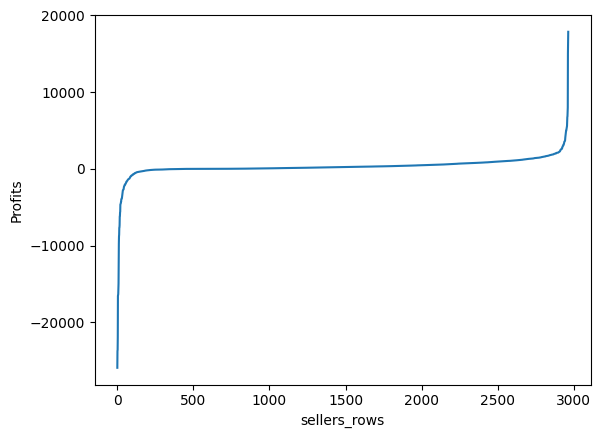

In [41]:
sorted_profits.profits.plot()
plt.xlabel('sellers_rows'); plt.ylabel('Profits')

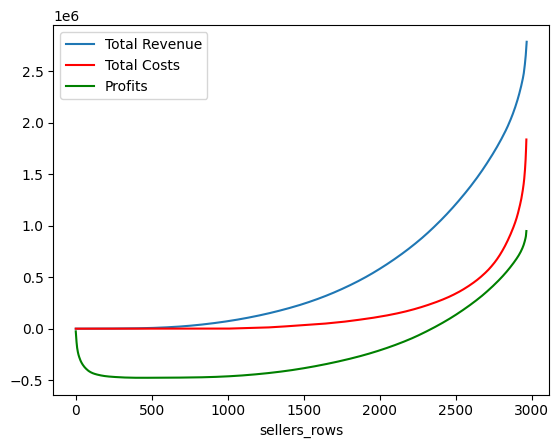

In [42]:
# Revenues
np.cumsum(sorted_sellers_1.revenues).plot( label ='Total Revenue');
plt.xlabel('sellers_rows'); 
# Costs
np.cumsum(sorted_costs.costs).plot(color = 'r', label = 'Total Costs');
# Profits
np.cumsum(sorted_profits.profits).plot(color = 'green', label = 'Profits');

plt.legend()

In [44]:
sellers.head()

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,review_score,cost_of_reviews,n_orders,quantity,quantity_per_order,sales,revenues,profits
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,0.333333,0.333333,3.00,140,3,3,1.000,218.70,341.870,201.870
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,0.050000,0.725000,4.55,240,40,41,1.025,11703.07,2290.307,2050.307
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,0.000000,1.000000,5.00,0,1,1,1.000,158.00,15.800,15.800
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.0,0.000000,1.000000,5.00,0,1,1,1.000,79.99,7.999,7.999
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,0.0,1.000000,0.000000,1.00,100,1,1,1.000,167.99,16.799,-83.201


In [45]:
profits_seller = sellers.merge(olist_costs, on = 'seller_id')

In [48]:
profits_seller = profits_seller[ ['seller_id', 
                                  'n_orders', 'revenues',
                                  'costs'  , 'sales' ] ]

profits_seller

,seller_id,n_orders,revenues,costs,sales
0,3442f8959a84dea7ee197c632cb2df15,3,341.870,140,218.70
1,d1b65fc7debc3361ea86b5f14c68d2e2,40,2290.307,140,11703.07
2,ce3ad9de960102d0677a81f5d0bb7b2d,1,15.800,0,158.00
3,c0f3eea2e14555b6faeea3dd58c1b1c3,1,7.999,0,79.99
4,51a04a8a6bdcb23deccc82b0b80742cf,1,16.799,100,167.99
...,...,...,...,...,...
2960,98dddbc4601dd4443ca174359b237166,2,15.800,0,158.00
2961,f8201cab383e484733266d1906e2fdfa,10,1208.900,140,889.00
2962,74871d19219c7d518d0090283e03c137,6,455.004,0,550.04
2963,e603cf3fec55f8697c9059638d6c8eb5,8,349.700,0,297.00


In [49]:
profits_seller['profits'] = profits_seller['revenues'] - profits_seller['costs']

In [51]:
profits_seller

,seller_id,n_orders,revenues,costs,sales,profits
0,3442f8959a84dea7ee197c632cb2df15,3,341.870,140,218.70,201.870
1,d1b65fc7debc3361ea86b5f14c68d2e2,40,2290.307,140,11703.07,2150.307
2,ce3ad9de960102d0677a81f5d0bb7b2d,1,15.800,0,158.00,15.800
3,c0f3eea2e14555b6faeea3dd58c1b1c3,1,7.999,0,79.99,7.999
4,51a04a8a6bdcb23deccc82b0b80742cf,1,16.799,100,167.99,-83.201
...,...,...,...,...,...,...
2960,98dddbc4601dd4443ca174359b237166,2,15.800,0,158.00,15.800
2961,f8201cab383e484733266d1906e2fdfa,10,1208.900,140,889.00,1068.900
2962,74871d19219c7d518d0090283e03c137,6,455.004,0,550.04,455.004
2963,e603cf3fec55f8697c9059638d6c8eb5,8,349.700,0,297.00,349.700


In [52]:
sorted_profits = profits_seller .sort_values(by = 'profits').reset_index()
sorted_profits.head(2)

,index,seller_id,n_orders,revenues,costs,sales,profits
0,453,1f50f920176fa81dab994f9023523100,1404,12053.921,37950,106939.21,-25896.079
1,1131,7c67e1448b00f6e969d365cea6b010ab,982,20232.389,43990,187923.89,-23757.611


In [53]:
sorted_profits.tail(2)

,index,seller_id,n_orders,revenues,costs,sales,profits
2963,67,7e93a43ef30c4f03f38b393420bc753a,336,19323.187,3260,176431.87,16063.187
2964,868,53243585a1d6dc2643021fd1853d8905,358,23237.605,5350,222776.05,17887.605


In [54]:
print(" The resulting profits for all sellers : ", round( sorted_profits.profits.sum(), 2) )

 The resulting profits for all sellers :  947232.32


Text(0, 0.5, 'Profits')

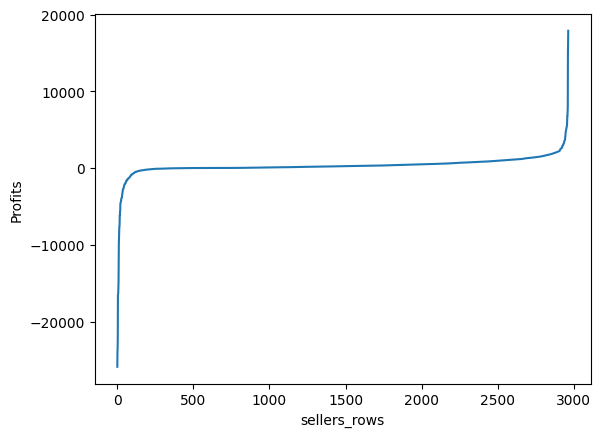

In [55]:
sorted_profits.profits.plot()
plt.xlabel('sellers_rows'); plt.ylabel('Profits')

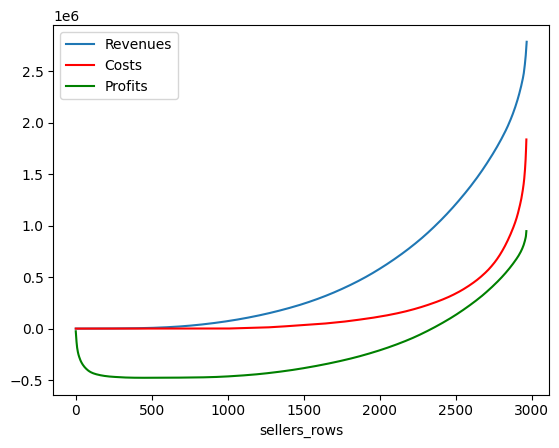

In [56]:
# Revenues
np.cumsum(sorted_sellers_1.revenues).plot( label ='Revenues');
plt.xlabel('sellers_rows'); 
# Costs
np.cumsum(sorted_costs.costs).plot(color = 'r', label = 'Costs');
# Profits
np.cumsum(sorted_profits.profits).plot(color = 'green', label = 'Profits');

plt.legend()

# Number of Orders

In [58]:
profits_seller.head(3)
profits_seller.shape

(2965, 6)

In [59]:
olist_costs.head(2)
olist_costs.shape

(2965, 2)

In [60]:
sellers_2 = profits_seller.merge(olist_costs,
                            on = 'seller_id')

In [61]:
sellers_2.head(3)

,seller_id,n_orders,revenues,costs_x,sales,profits,costs_y
0,3442f8959a84dea7ee197c632cb2df15,3,341.870,140,218.70,201.870,140
1,d1b65fc7debc3361ea86b5f14c68d2e2,40,2290.307,140,11703.07,2150.307,140
2,ce3ad9de960102d0677a81f5d0bb7b2d,1,15.800,0,158.00,15.800,0


In [66]:
sellers_3 = sellers_2.merge( sellers[[ 'seller_id', 'review_score']])
sellers_3

,seller_id,n_orders,revenues,costs_x,sales,profits,costs_y,review_score
0,3442f8959a84dea7ee197c632cb2df15,3,341.870,140,218.70,201.870,140,3.00
1,d1b65fc7debc3361ea86b5f14c68d2e2,40,2290.307,140,11703.07,2150.307,140,4.55
2,ce3ad9de960102d0677a81f5d0bb7b2d,1,15.800,0,158.00,15.800,0,5.00
3,c0f3eea2e14555b6faeea3dd58c1b1c3,1,7.999,0,79.99,7.999,0,5.00
4,51a04a8a6bdcb23deccc82b0b80742cf,1,16.799,100,167.99,-83.201,100,1.00
...,...,...,...,...,...,...,...,...
2960,98dddbc4601dd4443ca174359b237166,2,15.800,0,158.00,15.800,0,5.00
2961,f8201cab383e484733266d1906e2fdfa,10,1208.900,140,889.00,1068.900,140,4.10
2962,74871d19219c7d518d0090283e03c137,6,455.004,0,550.04,455.004,0,5.00
2963,e603cf3fec55f8697c9059638d6c8eb5,8,349.700,0,297.00,349.700,0,4.25


In [70]:
mask_columns = ['seller_id', 'n_orders', 'revenues', 
       'sales', 'profits','review_score']
sellers_3 = sellers_3[mask_columns].copy()

In [71]:
sellers_3["Rank_profits"] = sellers_3["profits"].rank()
sellers_3.sort_values(by = 'n_orders', ascending = False).head(3)

,seller_id,n_orders,revenues,sales,profits,review_score,Rank_profits
769,6560211a19b47992c3666cc44a7e94c0,1854,13770.483,123304.83,-23609.517,3.937093,3.0
2357,4a3ca9315b744ce9f8e9374361493884,1806,21647.292,200472.92,-21862.708,3.827873,4.0
1356,cc419e0650a3c5ba77189a1882b7556a,1706,11948.842,104288.42,-15631.158,4.077586,8.0


In [72]:
print( " the total cumulated number of orders approved. : ", sellers_3['n_orders'].sum() )

 the total cumulated number of orders approved. :  99836


## The number of orders vs. profits and order vs. review_score

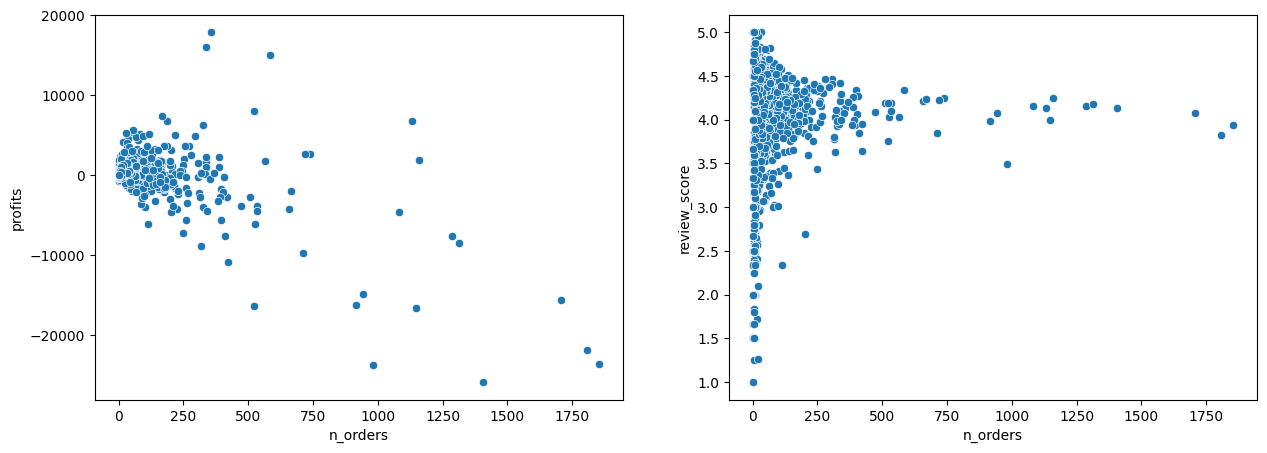

In [73]:
fig,axes=plt.subplots(1,2, figsize=(15,5))
sns.scatterplot(x='n_orders', y='profits', data=sellers_3 ,ax=axes[0])
sns.scatterplot(x='n_orders', y='review_score', data=sellers_3, ax=axes[1]);

n_orders higher and average(review_score) higher but profits are the more disastrous

In [74]:
len(sellers_3['seller_id'].unique()) == len(olist_costs['seller_id'].unique()) 

True

In [75]:
len(sellers_3['seller_id'].unique())

2965

## Sellers Decision

In [76]:
sellers_1.head(2)

,seller_id,date_first_sale,date_last_sale,sales,active_months,revenues,revenues2
0,3442f8959a84dea7ee197c632cb2df15,2017-05-05 16:25:11,2017-08-30 12:50:19,218.70,3.839119,328.999525,328.999525
1,d1b65fc7debc3361ea86b5f14c68d2e2,2017-03-29 02:10:34,2018-06-06 20:15:21,11703.07,14.283770,2313.008599,2313.008599


In [77]:
sellers_rate_price = sellers_1. copy()

sellers_rate_price['active_months'] = \
          (sellers_rate_price['date_last_sale'] - sellers_rate_price['date_first_sale']) \
                  / np.timedelta64(1,'M')

sellers_rate_price['revenues'] = sellers_rate_price['sales'].map(lambda x : .15*x) \
                       + sellers_rate_price['active_months']*80

total_revenues_rate_price = sellers_rate_price['revenues'].sum()

total_costs = olist_costs['costs'].sum() # remaining costs 
profits_rate_price =  total_revenues_rate_price - total_costs

IT_costs = 500_000

In [86]:
sellers_rate_price.drop(columns='revenues2')

,seller_id,date_first_sale,date_last_sale,sales,active_months,revenues
0,3442f8959a84dea7ee197c632cb2df15,2017-05-05 16:25:11,2017-08-30 12:50:19,218.70,3.839119,339.934525
1,d1b65fc7debc3361ea86b5f14c68d2e2,2017-03-29 02:10:34,2018-06-06 20:15:21,11703.07,14.283770,2898.162099
2,ce3ad9de960102d0677a81f5d0bb7b2d,2018-07-30 12:44:49,2018-07-30 12:44:49,158.00,0.000000,23.700000
3,c0f3eea2e14555b6faeea3dd58c1b1c3,2018-08-03 00:44:08,2018-08-03 00:44:08,79.99,0.000000,11.998500
4,51a04a8a6bdcb23deccc82b0b80742cf,2017-11-14 12:15:25,2017-11-14 12:15:25,167.99,0.000000,25.198500
...,...,...,...,...,...,...
2962,98dddbc4601dd4443ca174359b237166,2018-07-14 03:10:19,2018-07-23 15:34:03,158.00,0.312663,48.713032
2963,f8201cab383e484733266d1906e2fdfa,2017-06-17 15:30:11,2018-08-11 19:55:17,889.00,13.805100,1237.757985
2964,74871d19219c7d518d0090283e03c137,2018-04-05 17:09:46,2018-08-21 19:25:15,550.04,4.537065,445.471214
2965,e603cf3fec55f8697c9059638d6c8eb5,2017-02-09 02:43:17,2017-06-16 17:30:16,297.00,4.192808,379.974608


In [87]:
print("Revenues for all sellers 15%:", total_revenues_rate_price)
print( " The total resulting profits 15%: ", round(profits_rate_price, 2))
print("The final resulting profits 15%: ",  round(profits_rate_price - IT_costs, 2))

Revenues for all sellers 15%: 3464856.656282712
 The total resulting profits 15%:  1627026.66
The final resulting profits 15%:  1127026.66


In [88]:
print("Revenues for all sellers 10%:", total_revenues)
print( " The total resulting profits 10%: ", round(profits, 2))
print("The final resulting profits 10%: ",  round(profits - IT_costs, 2))

Revenues for all sellers 10%: 2787067.4342827117
 The total resulting profits 10%:  949237.43
The final resulting profits 10%:  449237.43
